<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd
import skimage.io
import tqdm


from sklearn.model_selection import train_test_split
from skimage.transform import resize
%matplotlib inline

import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

In [2]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values).astype('float32')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [3]:
data, attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [4]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_photos.transpose(0, 3, 1, 2), batch_size=32)
val_loader = torch.utils.data.DataLoader(val_photos.transpose(0, 3, 1, 2), batch_size=32)

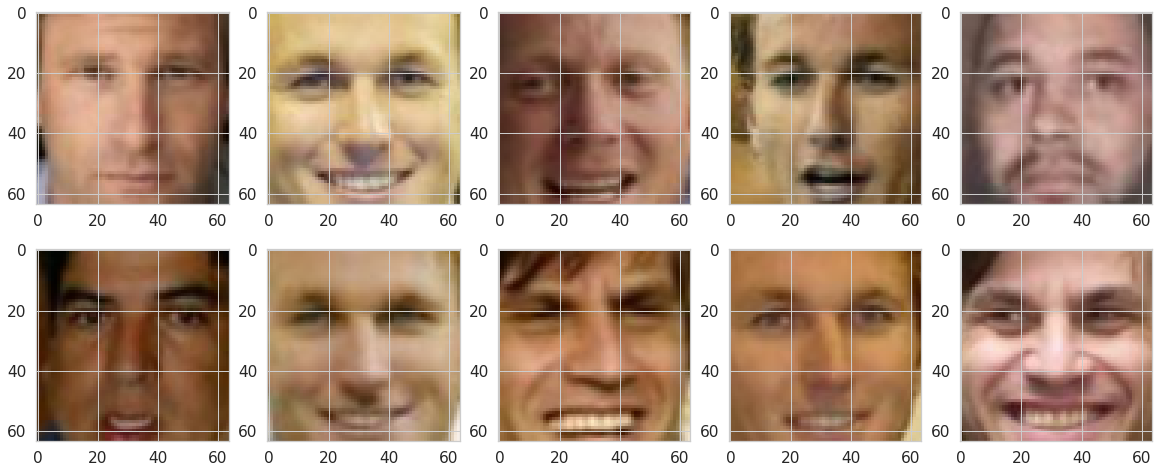

In [5]:
plt.figure(figsize=(20, 8))
for i, (gt, res) in enumerate(zip(train_photos[:5], train_photos[5:10])):
  plt.subplot(2, 5, 2*i+1)
  plt.imshow(gt)
  plt.subplot(2, 5, 2*i+2)
  plt.imshow(res)

### 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [6]:
dim_code = 128 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [7]:
from copy import deepcopy

class Simple_Autoencoder(nn.Module):
    def __init__(self):
        super(Simple_Autoencoder, self).__init__()

        self.flatten = nn.Flatten()
 
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=3*64*64, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=dim_code),
            nn.ReLU()
        )
 
        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(in_features=dim_code, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=3*64*64)
        )
        
    def forward(self, x):
        x = self.flatten(x).float()
        # print("X SHAPE AFTER FLATTEN: ", x.shape)
        latent_code = self.encoder(x).view(-1, dim_code)
        # print("X SHAPE AFTER ENCODING: ", latent_code.shape)

        reconstruction = self.decoder(latent_code)
        # print('X SHAPE AFTER DECODER', reconstruction.shape)
        
        return reconstruction

    def sample(self, z):
        generated = self.decoder(z)
        generated = generated.view(-1, 3, 64, 64)
        return generated

In [8]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [9]:
def train(model, optimizer, criterion, n_epochs=20):
    train_losses = []
    val_losses = []

    for epoch in tqdm.trange(n_epochs):
        model.train()
        train_losses_per_epoch = []
        for X_batch in train_loader:
            # print("\n X_batch.shape = ", X_batch.shape)
            optimizer.zero_grad()
            reconstruction = model(X_batch.to(device))
            # print("\n reconstruction.shape BEFORE: ", reconstruction.shape)
            reconstruction = reconstruction.view(-1, 3, 64, 64)
            # print("\n reconstruction.shape AFTER: ", reconstruction.shape)
            loss = criterion(reconstruction, X_batch.to(device))
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())
        train_losses.append(np.mean(train_losses_per_epoch))

        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for X_batch in val_loader:
                reconstruction = model(X_batch.to(device))
                reconstruction = reconstruction.view(-1, 3, 64, 64)
                loss = criterion(X_batch.to(device).float(), reconstruction)
                val_losses_per_epoch.append(loss.item())

        val_losses.append(np.mean(val_losses_per_epoch))

    return train_losses, val_losses

In [10]:
def show_image(ground_truth, result, start_index=0):
    plt.figure(figsize=(20, 8))
    for k in range(6):
        plt.subplot(2, 6, k+1)
        plt.imshow(np.rollaxis(ground_truth[start_index+k], 0, 3), cmap='gray')
        plt.title('Real')
        plt.axis('off')

        plt.subplot(2, 6, k+7)
        plt.imshow(result[start_index+k].transpose(1, 2, 0), cmap='gray')
        plt.title('Output')
        plt.axis('off')
    plt.show()

In [11]:
def eval(model, val_loader, start_index=0):
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
          reconstruction = model(batch.to(device))
          reconstruction = reconstruction.view(-1, 3, 64, 64)
          result = reconstruction.cpu().detach().numpy()
          ground_truth = batch.numpy()
          break

    show_image(ground_truth, result, start_index)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [12]:
criterion = F.mse_loss #nn.MSELoss()
simple_autoencoder = Simple_Autoencoder().to(device)
optimizer = torch.optim.Adam(simple_autoencoder.parameters(), lr=1e-3)
train_losses, val_losses = train(simple_autoencoder, optimizer, criterion, n_epochs=20) # < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

100%|██████████| 20/20 [00:41<00:00,  2.06s/it]


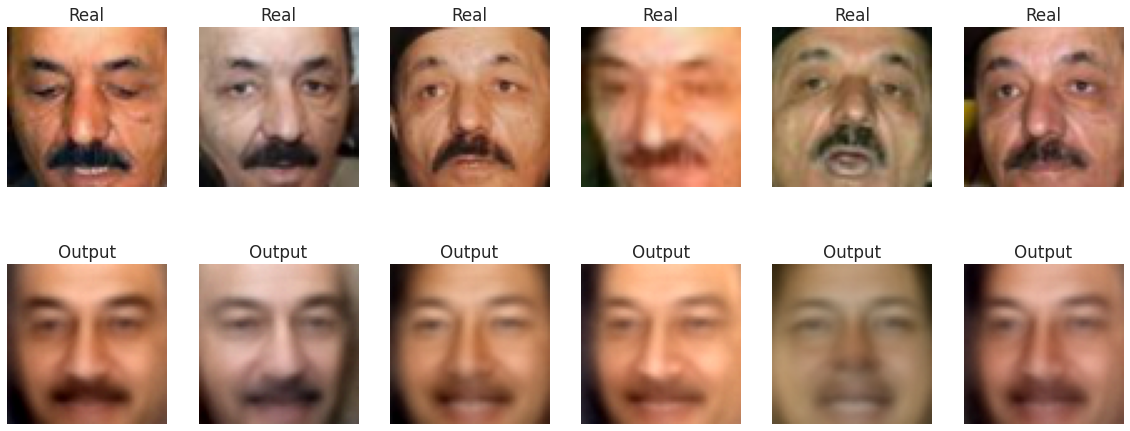

In [13]:
eval(simple_autoencoder, val_loader, start_index=10)

In [14]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),
            nn.ReLU(True),
            nn.Conv2d(6,16,kernel_size=5),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(in_features=16*56*56, out_features=dim_code)
        )

        self.decoder = nn.Sequential(        
            nn.Linear(in_features=dim_code, out_features=16*56*56),
            nn.Unflatten(1, (16, 56, 56)),
            nn.ConvTranspose2d(16,6,kernel_size=5),
            nn.ReLU(True),
            nn.ConvTranspose2d(6,3,kernel_size=5),
            # nn.ReLU(True),
            nn.Sigmoid()
        )

    def forward(self,x):
        x = self.encoder(x)#.view(-1, dim_code)
        x = self.decoder(x)
        return x

    def sample(self, x):
        generated = self.decoder(x)
        return generated

    def get_latent_vector(self, x):
        latent_code = self.encoder(x)#.view(-1, dim_code)
        return latent_code

In [15]:
criterion = F.mse_loss #nn.MSELoss()
autoencoder = Autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
train_losses, val_losses = train(autoencoder, optimizer, criterion, n_epochs=30) # < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

100%|██████████| 30/30 [02:55<00:00,  5.84s/it]


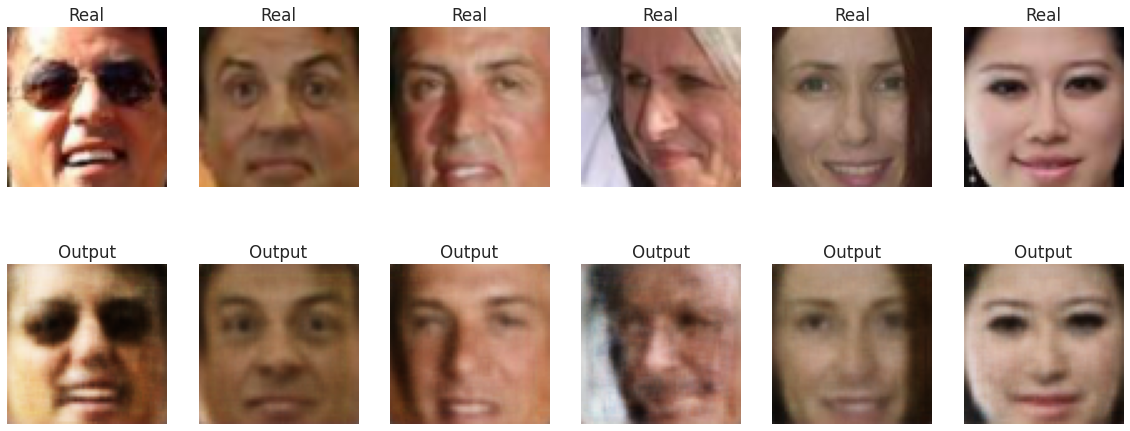

In [16]:
eval(autoencoder, val_loader, start_index=0)

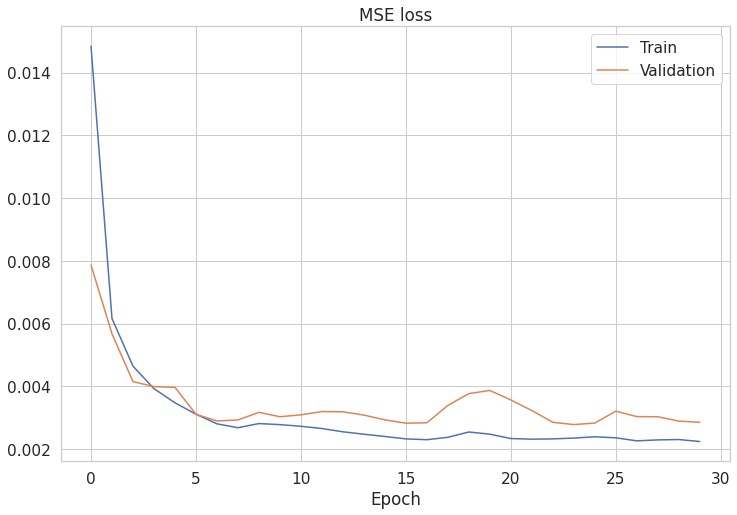

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

Подсказка:Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [18]:
model = autoencoder

In [19]:
for batch in val_loader:
    latent_vector = model.get_latent_vector(batch.to(device))  
    break  
latent_vector.shape

torch.Size([32, 128])

In [20]:
latent_mean = latent_vector.mean(dim=0)
latent_std = latent_vector.std(dim=0)

In [21]:
latent_mean = latent_mean.cpu().detach().numpy()
latent_std = latent_std.cpu().detach().numpy()

In [22]:
latent_mean.shape, latent_std.shape

((128,), (128,))

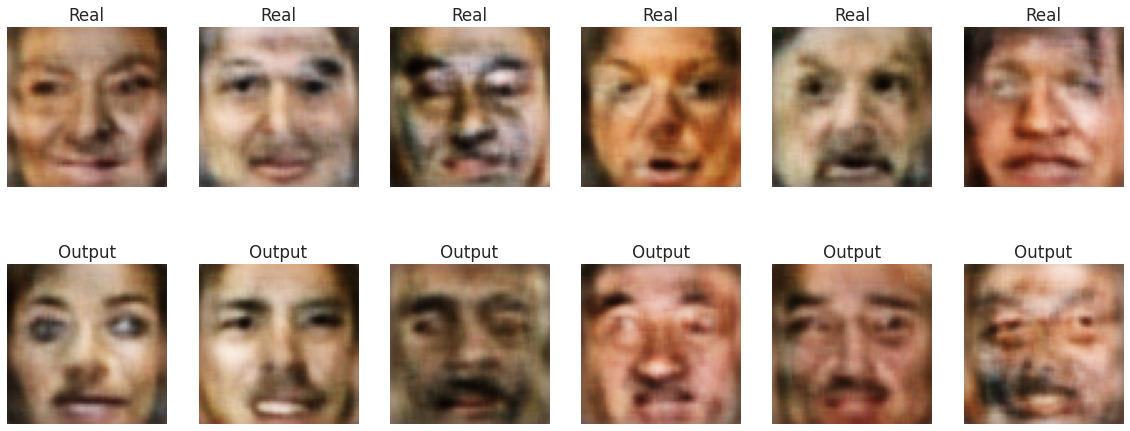

In [23]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.array([np.random.normal(0, 1, dim_code) for i in range(32)])
z = z * latent_std + latent_mean

model.eval()
with torch.no_grad():
    reconstruction = model.sample(torch.FloatTensor(z).to(device))
    reconstruction = reconstruction
    output = reconstruction.cpu().detach().numpy()

show_image(output[:16, :, :, :], output[16:, :, :, :])

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [24]:
train_attrs.head(20)

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,...,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559
2,0.997749,-1.36419,-0.157377,-0.756447,-1.89183,-0.871526,-0.862893,0.0314447,-1.34152,-0.0900375,...,1.54974,1.88475,-0.999765,-1.35986,-1.91211,-1.09563,0.915126,-0.572332,0.144262,-0.841231
3,1.12272,-1.9978,1.91614,-2.51421,-2.58007,-1.40424,0.0575511,0.000195882,-1.27351,-1.43146,...,0.567822,-0.176089,1.10812,-1.60094,-3.26461,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.07821,-2.0081,1.67621,-2.27806,-2.65185,-1.34841,0.649089,0.0176564,-1.88911,-1.85721,...,-1.46147,-0.955283,0.119113,-1.12818,-3.16105,0.0826804,-0.439614,-0.359859,-0.760774,-0.410152
5,0.850491,-1.48208,1.90852,-1.87365,-3.22993,-0.864006,0.31382,-0.35268,-1.55929,-1.91459,...,1.77547,-1.0635,1.35435,-0.960133,-5.35464,1.15002,-0.142195,-0.672725,0.886694,-0.154051
6,0.944548,-1.37722,1.29906,-1.40534,-1.86233,-0.502664,-0.48629,0.0150016,-0.892478,-0.586615,...,0.155763,-0.0333257,-0.869705,-0.942216,-3.77615,-1.0283,0.0992853,-0.335493,0.185644,-0.671966
7,1.59467,-1.50443,0.441401,-1.77175,-2.44985,-1.10597,-0.0425912,-0.136437,-1.00851,0.653294,...,-3.25803,0.128691,-1.57324,-1.10214,-1.12391,-1.39417,1.52065,-0.487475,0.601968,-0.617698
8,0.286489,-1.90351,0.697239,-1.85985,-1.44025,-1.55243,0.102555,-0.191471,-0.726333,-0.226157,...,-1.41784,-0.483956,0.717483,-0.288405,-2.29545,0.937971,1.23307,-0.632812,0.00999485,-0.144265
9,0.663497,-1.03694,0.46161,-2.49853,-2.81593,-1.63779,-0.20148,-0.134941,-1.32816,-0.712721,...,1.43291,0.771419,1.59549,-0.697505,-2.51197,0.98124,0.424768,-0.518236,-0.306921,0.348492


In [26]:
model = autoencoder

In [27]:
funny_mask = train_attrs['Smiling'] > 2
funny_people_dl = torch.utils.data.DataLoader(train_photos[funny_mask].transpose(0, 3, 1, 2), batch_size=32)

In [28]:
for batch in funny_people_dl:
    funny_latent_vector = model.get_latent_vector(batch.to(device))
    break

In [29]:
sad_mask = train_attrs['Smiling'] < -2
sad_people_dl = torch.utils.data.DataLoader(train_photos[sad_mask].transpose(0, 3, 1, 2), batch_size=32)

In [30]:
for batch in sad_people_dl:
    sad_latent_vector = model.get_latent_vector(batch.to(device))
    break

In [31]:
smile_latent_vector = funny_latent_vector.mean(dim=0) - sad_latent_vector.mean(dim=0)

In [32]:
for batch in val_loader:
    latent_vector = model.get_latent_vector(batch.to(device))
    latent_vector += smile_latent_vector # make smile here
    result = model.sample(latent_vector.to(device))

    result = result.cpu().detach().numpy()
    ground_truth = batch.numpy()
    break

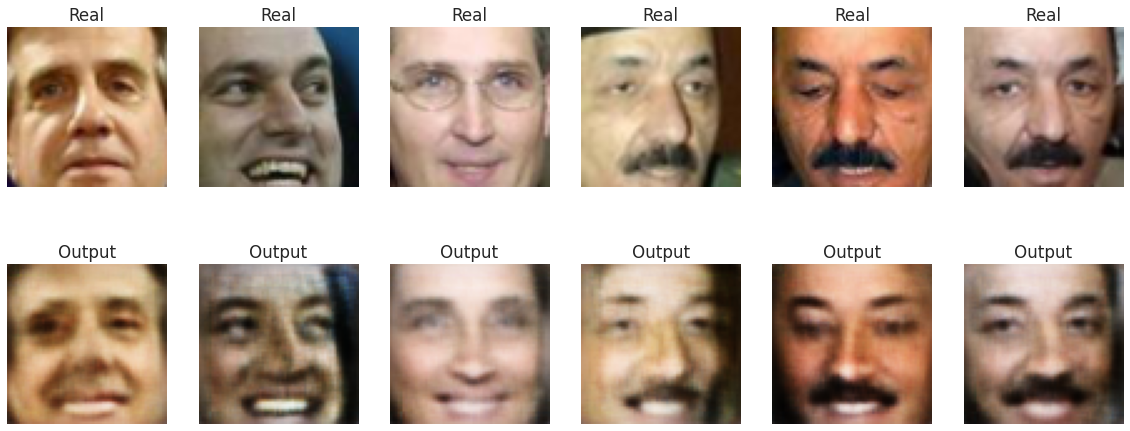

In [33]:
show_image(ground_truth, result, 6)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [34]:
from torchvision import transforms

In [35]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

0it [00:00, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [37]:
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [38]:
dim_code = 8

In [39]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста", 
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=3),
            nn.ReLU(True),
            nn.Conv2d(6,16,kernel_size=3),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(in_features=16*24*24, out_features=2*dim_code)
        )

        self.decoder = nn.Sequential(        
            nn.Linear(in_features=dim_code, out_features=16*24*24),
            nn.Unflatten(1, (16, 24, 24)),
            nn.ConvTranspose2d(16,6,kernel_size=3),
            nn.ReLU(True),
            nn.ConvTranspose2d(6,1,kernel_size=3),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu, logsigma = torch.split(x, dim_code, dim=1)
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            std = torch.exp(logsigma)
            eps = torch.randn_like(std)
            sample = eps * std + mu
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        # <реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction>
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        # print('x.shape', x.shape)

        mu, logsigma = self.encode(x)
        latent_code = self.gaussian_sampler(mu, logsigma)
        
        # print('latent_code.shape', latent_code.shape)
        reconstruction = self.decoder(latent_code)

        return mu, logsigma, reconstruction

    def get_latent_vector(self, x):
        # print('BEFORE x.shape', x.shape)
        x = self.encoder(x)
        # print('AFTER x.shape', x.shape)
        mu, logsigma = torch.split(x, dim_code, dim=1)
        latent_code = self.gaussian_sampler(mu, logsigma)

        return latent_code

    def sample(self, x):
        generated = self.decoder(x)
        return generated

In [40]:
def train(model, optimizer, criterion, val_loader, n_epochs=20):
    train_losses = []
    val_losses = []

    for epoch in tqdm.trange(n_epochs):
        model.train()
        train_losses_per_epoch = []
        for X_batch, _ in val_loader:
            optimizer.zero_grad()
            mu, logsigma, reconstruction = model(X_batch.to(device))
            loss = criterion(X_batch.to(device).float(), mu, logsigma, reconstruction)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))

        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for X_batch, _ in val_loader:
              mu, logsigma, reconstruction = model(X_batch.to(device))
              loss = criterion(X_batch.to(device).float(), mu, logsigma, reconstruction)
              val_losses_per_epoch.append(loss.item())

        val_losses.append(np.mean(val_losses_per_epoch))

    return train_losses, val_losses

In [41]:
def show_image(ground_truth, result, img_cnt, start_index=0):
    plt.figure(figsize=(25, 8))
    for k in range(img_cnt):
        plt.subplot(2, img_cnt, k+1)
        plt.imshow(ground_truth[start_index+k].reshape(28, 28), cmap='gray')
        plt.title('Real')
        plt.axis('off')

        plt.subplot(2, img_cnt, k+1+img_cnt)
        plt.imshow(result[start_index+k].reshape(28, 28), cmap='gray')
        plt.title('Output')
        plt.axis('off')
    plt.show()

In [42]:
def eval(model, val_loader, start_index=0):
    model.eval()
    with torch.no_grad():
        for X_batch, _ in val_loader:
          mu, logsigma, reconstruction = model(X_batch.to(device))
          result = reconstruction.cpu().detach().numpy()
          ground_truth = X_batch.numpy()
          img_cnt = min(6, X_batch.shape[0])
          break
          
    show_image(ground_truth, result, img_cnt, start_index)

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [43]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu**2 - torch.exp(logsigma))
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [44]:
criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

In [45]:
train_losses, val_losses = train(autoencoder, optimizer, criterion, test_loader, n_epochs=50)





  0%|          | 0/50 [00:00<?, ?it/s]



  2%|▏         | 1/50 [00:03<03:12,  3.94s/it]



  4%|▍         | 2/50 [00:07<03:04,  3.85s/it]



  6%|▌         | 3/50 [00:11<02:58,  3.79s/it]



  8%|▊         | 4/50 [00:15<02:55,  3.82s/it]



 10%|█         | 5/50 [00:19<02:50,  3.78s/it]



 12%|█▏        | 6/50 [00:22<02:45,  3.75s/it]



 14%|█▍        | 7/50 [00:26<02:43,  3.80s/it]



 16%|█▌        | 8/50 [00:30<02:43,  3.88s/it]



 18%|█▊        | 9/50 [00:34<02:36,  3.82s/it]



 20%|██        | 10/50 [00:38<02:35,  3.88s/it]



 22%|██▏       | 11/50 [00:42<02:28,  3.82s/it]



 24%|██▍       | 12/50 [00:45<02:26,  3.85s/it]



 26%|██▌       | 13/50 [00:49<02:20,  3.80s/it]



 28%|██▊       | 14/50 [00:53<02:16,  3.78s/it]



 30%|███       | 15/50 [00:57<02:14,  3.84s/it]



 32%|███▏      | 16/50 [01:01<02:13,  3.93s/it]



 34%|███▍      | 17/50 [01:05<02:07,  3.87s/it]



 36%|███▌      | 18/50 [01:09<02:05,  3.91s/it]



 38%|███▊      | 19/50 [01:12<01:59,  3.85s/i

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

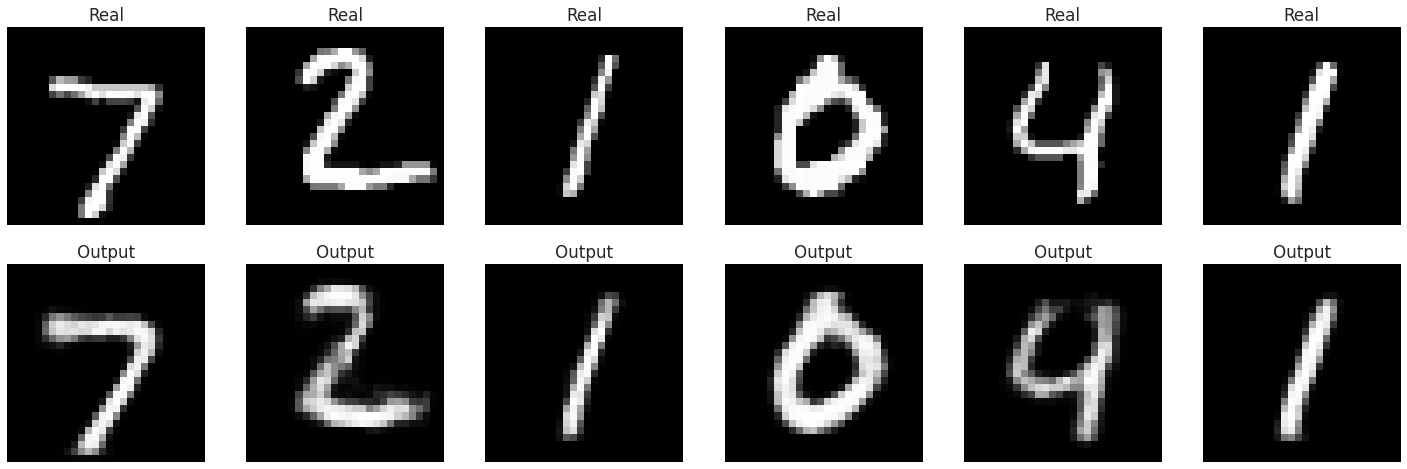

In [46]:
eval(autoencoder, test_loader, start_index=0)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [47]:
model = autoencoder

In [48]:
for X_batch, y_batch in test_loader:
    latent_vector = model.get_latent_vector(X_batch.to(device))  
    break  

latent_vector.shape

torch.Size([32, 8])

In [49]:
latent_mean = latent_vector.mean(dim=0)
latent_std = latent_vector.std(dim=0)

latent_mean = latent_mean.cpu().detach().numpy()
latent_std = latent_std.cpu().detach().numpy()

latent_mean, latent_std

(array([-0.06217058, -0.27118868, -0.0884558 ,  0.06827693, -0.2467254 ,
         0.26059115, -0.02834315,  0.16388139], dtype=float32),
 array([0.6383064 , 0.7079045 , 0.77340406, 0.8505193 , 0.72920024,
        0.6551569 , 0.49802622, 0.6708527 ], dtype=float32))

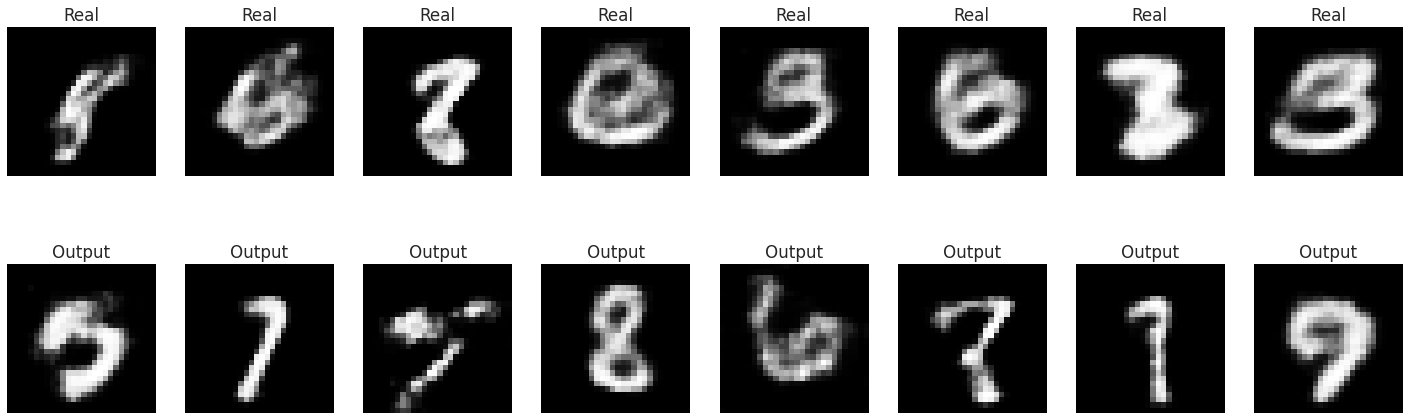

In [50]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.array([np.random.normal(0, 1, dim_code) for i in range(32)])
z = z * latent_std + latent_mean

model.eval()
with torch.no_grad():
    reconstruction = model.sample(torch.FloatTensor(z).to(device))
    output = reconstruction.cpu().detach().numpy()

show_image(output[:16, :, :, :], output[16:, :, :, :], 8)

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [51]:
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [52]:
test_loader = iter(test_loader)
X_batch, y_batch = next(test_loader)

In [53]:
latent_vector_list = model.get_latent_vector(X_batch.to(device))
labels = y_batch.reshape(-1, 1)
for X_batch, y_batch in test_loader:
    batch_sample = model.get_latent_vector(X_batch.to(device))
    latent_vector_list = torch.vstack((latent_vector_list, batch_sample))
    labels = torch.vstack((labels, y_batch.reshape(-1, 1)))

In [54]:
latent_vector_list.shape

torch.Size([10000, 8])

In [55]:
latent_vector_list = latent_vector_list.detach().cpu()
labels = labels.detach().cpu()

In [56]:
from sklearn.manifold import TSNE

In [57]:
X_embedded = TSNE(n_components=2).fit_transform(latent_vector_list)
X_embedded.shape

(10000, 2)

In [58]:
X_embedded[:,0].shape

(10000,)

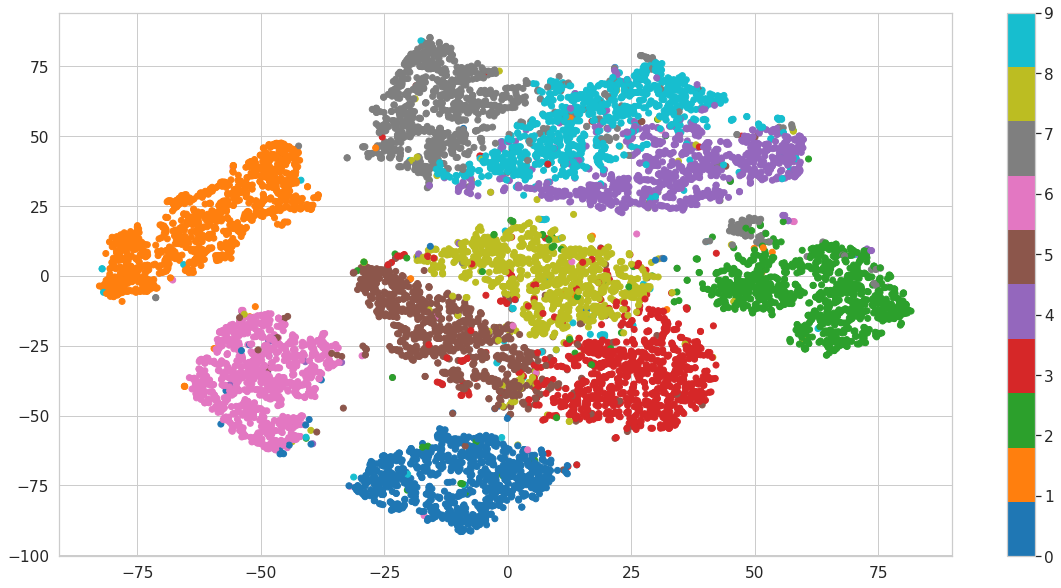

In [59]:
plt.figure(figsize=[20, 10])
graph = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=labels, cmap='tab10')
plt.colorbar(graph)
plt.colormaps()
plt.show()

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [60]:
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [61]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста", 
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>

        # encoder
        self.enc_fc1 = nn.Linear(in_features=28*28+10, out_features=128)
        self.enc_ac1 = nn.ReLU()
        self.enc_fc2 = nn.Linear(in_features=128, out_features=64)
        self.enc_ac2 = nn.ReLU()
        self.enc_fc3 = nn.Linear(in_features=64, out_features=2*dim_code)

        # decoder
        self.dec_fc1 = nn.Linear(in_features=dim_code+10, out_features=64)
        self.dec_ac1 = nn.ReLU()
        self.dec_fc2 = nn.Linear(in_features=64, out_features=128)
        self.dec_ac2 = nn.ReLU()
        self.dec_fc3 = nn.Linear(in_features=128, out_features=28*28)
        self.dec_ac3 = nn.Sigmoid()

    def encode(self, x, class_num):
        # <реализуйте forward проход энкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и класс картинки>
        
        # decoder
        x = x.reshape(-1, 28*28)
        one_hot = F.one_hot(class_num, num_classes=10)
        x = (torch.hstack((one_hot, x))) # stacking 1

        x = self.enc_fc1(x)
        x = self.enc_ac1(x)
        x = self.enc_fc2(x)
        x = self.enc_ac2(x) 
        x = self.enc_fc3(x)

        mu, logsigma = torch.split(x, dim_code, dim=1)

        return mu, logsigma, class_num
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            std = torch.exp(logsigma)
            eps = torch.randn_like(std)
            sample = eps * std + mu
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        # <реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction>
        
        
        # print('z.shape =', z.shape)
        z = self.dec_ac1(self.dec_fc1(z))
        z = self.dec_ac2(self.dec_fc2(z))
        z = self.dec_fc3(z)
        z = z.view(-1, 1, 28, 28)
        reconstruction = self.dec_ac3(z)
        return reconstruction

    def forward(self, x, y):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        
        mu, logsigma, class_num = self.encode(x, y)
        latent_code = self.gaussian_sampler(mu, logsigma)

        one_hot = F.one_hot(class_num, num_classes=10)
        sample = torch.hstack((one_hot, latent_code))
        # print('forward sample.shape =', sample.shape)
        reconstruction = self.decode(sample) # stacking 2

        return mu, logsigma, reconstruction

    def sample(self, x):
        generated = self.decode(x)
        return generated

    def get_latent_vector(self, x, y):
        mu, logsigma, class_num = self.encode(x, y)
        latent_code = self.gaussian_sampler(mu, logsigma)
        one_hot = F.one_hot(class_num, num_classes=10)
        latent_code = torch.hstack((one_hot, latent_code))
        # print('get_latent latent_code.shape =', latent_code.shape)
        return latent_code

In [62]:
def train(model, optimizer, criterion, val_loader, n_epochs=20):
    
    train_losses = []
    val_losses = []

    for epoch in tqdm.trange(n_epochs):
        model.train()
        train_losses_per_epoch = []
        for X_batch, y_batch in val_loader:
            # print("y_batch.shape =", y_batch.shape)
            optimizer.zero_grad()
            mu, logsigma, reconstruction = model(X_batch.to(device), y_batch.to(device))
            # print("reconstruction.shape =", reconstruction.shape)
            loss = criterion(X_batch.to(device).float(), mu, logsigma, reconstruction)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))

        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
              mu, logsigma, reconstruction = model(X_batch.to(device), y_batch.to(device))
              loss = criterion(X_batch.to(device).float(), mu, logsigma, reconstruction)
              val_losses_per_epoch.append(loss.item())

        val_losses.append(np.mean(val_losses_per_epoch))

    return train_losses, val_losses

In [63]:
def eval(model, val_loader, start_index=0):
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
          mu, logsigma, reconstruction = model(X_batch.to(device), y_batch.to(device))
          result = reconstruction.cpu().detach().numpy()
          ground_truth = X_batch.numpy()
          img_cnt = min(6, X_batch.shape[0])
          break
          
    show_image(ground_truth, result, img_cnt, start_index)

In [64]:
criterion = loss_vae

cv_autoencoder = CVAE().to(device)

optimizer = torch.optim.Adam(cv_autoencoder.parameters(), lr=1e-3)

In [65]:
train_losses, val_losses = train(cv_autoencoder, optimizer, criterion, test_loader, n_epochs=50)





  0%|          | 0/50 [00:00<?, ?it/s]



  2%|▏         | 1/50 [00:02<02:23,  2.93s/it]



  4%|▍         | 2/50 [00:05<02:20,  2.92s/it]



  6%|▌         | 3/50 [00:08<02:21,  3.02s/it]



  8%|▊         | 4/50 [00:11<02:17,  2.98s/it]



 10%|█         | 5/50 [00:14<02:13,  2.96s/it]



 12%|█▏        | 6/50 [00:17<02:11,  2.99s/it]



 14%|█▍        | 7/50 [00:21<02:18,  3.22s/it]



 16%|█▌        | 8/50 [00:24<02:11,  3.13s/it]



 18%|█▊        | 9/50 [00:27<02:05,  3.06s/it]



 20%|██        | 10/50 [00:30<02:03,  3.08s/it]



 22%|██▏       | 11/50 [00:33<01:58,  3.03s/it]



 24%|██▍       | 12/50 [00:36<01:53,  2.99s/it]



 26%|██▌       | 13/50 [00:39<01:49,  2.97s/it]



 28%|██▊       | 14/50 [00:42<01:48,  3.03s/it]



 30%|███       | 15/50 [00:45<01:45,  3.00s/it]



 32%|███▏      | 16/50 [00:48<01:41,  2.98s/it]



 34%|███▍      | 17/50 [00:51<01:44,  3.17s/it]



 36%|███▌      | 18/50 [00:54<01:39,  3.10s/it]



 38%|███▊      | 19/50 [00:57<01:34,  3.04s/i

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [66]:
model = cv_autoencoder

In [67]:
for X_batch, y_batch in test_loader:
    latent_vector = model.get_latent_vector(X_batch.to(device), y_batch.to(device))  
    break

In [68]:
latent_mean = latent_vector.mean(dim=0)
latent_std = latent_vector.std(dim=0)

latent_mean = latent_mean.cpu().detach().numpy()
latent_std = latent_std.cpu().detach().numpy()

latent_mean.shape, latent_std.shape

((18,), (18,))

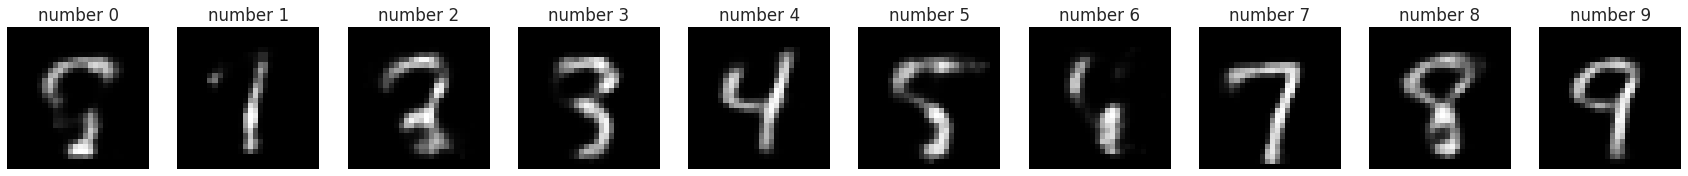

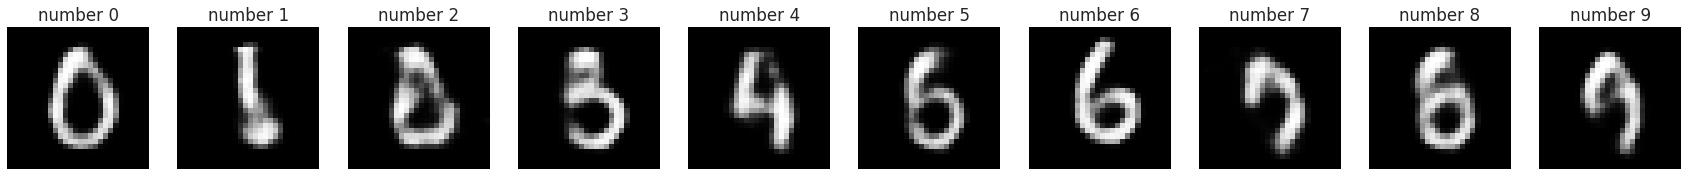

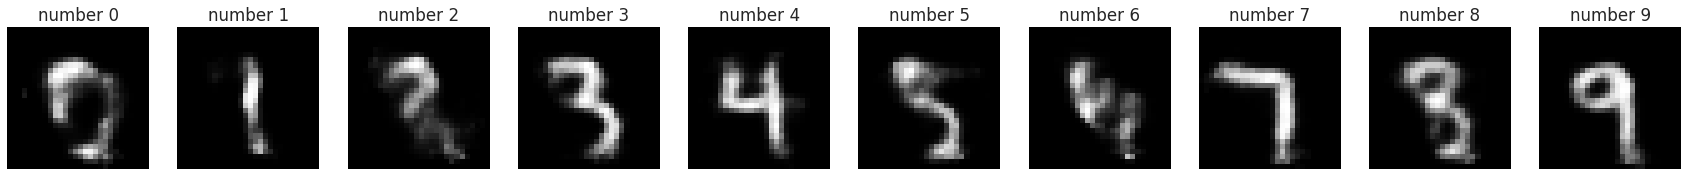

In [69]:
for i in range(3):
    z = np.random.randn(8) * latent_std[10:] + latent_mean[10:]
    z = torch.FloatTensor(z)

    plt.figure(figsize=[30, 20])
    for i in range(10):
        random_latent = torch.hstack((torch.zeros(10), z)).to(device)
        random_latent[i] = 1
        output = model.sample(random_latent).detach().cpu().reshape(28, 28)
        plt.subplot(1, 10, i+1)
        plt.imshow(output, cmap='gray') 
        plt.title(f'number {i}')
        plt.axis('off')
    plt.show()

In [70]:
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
test_loader = iter(test_loader)
X_batch, y_batch = next(test_loader)

In [71]:
latent_vector_list = model.get_latent_vector(X_batch.to(device), y_batch.to(device))
labels = y_batch.reshape(-1, 1)
for X_batch, y_batch in test_loader:
    batch_sample = model.get_latent_vector(X_batch.to(device), y_batch.to(device))
    latent_vector_list = torch.vstack((latent_vector_list, batch_sample))
    labels = torch.vstack((labels, y_batch.reshape(-1, 1)))

In [72]:
latent_vector_list.shape

torch.Size([10000, 18])

In [73]:
latent_vector_list = latent_vector_list.detach().cpu()
labels = labels.detach().cpu()

In [74]:
X_embedded = TSNE(n_components=2).fit_transform(latent_vector_list)
X_embedded.shape

(10000, 2)

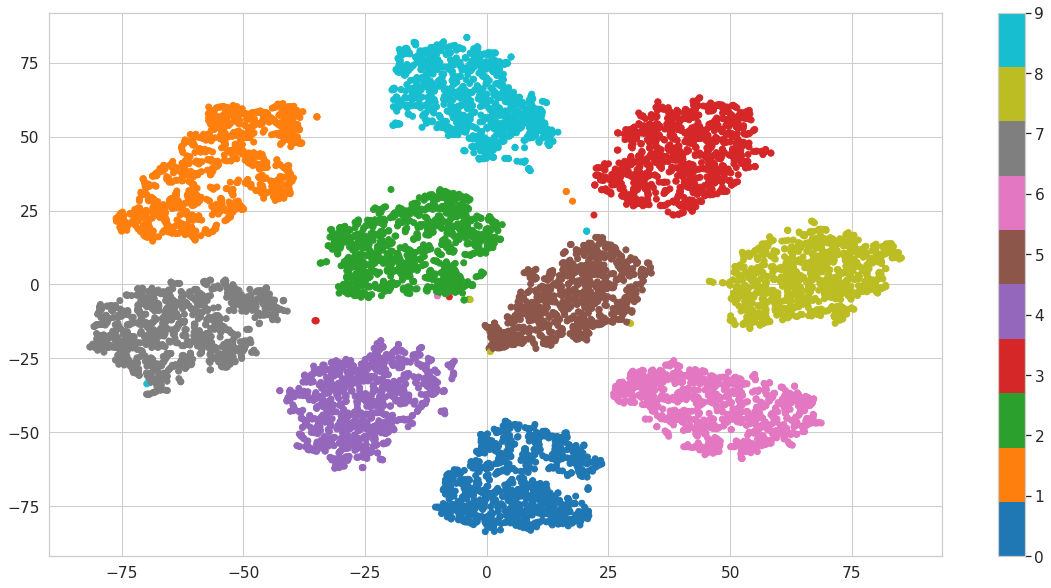

In [75]:
plt.figure(figsize=[20, 10])
graph = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=labels, cmap='tab10')
plt.colorbar(graph)
plt.colormaps()
plt.show()

In [76]:
latent_vector_list = latent_vector_list[:,10:]

In [77]:
X_embedded = TSNE(n_components=2).fit_transform(latent_vector_list)
X_embedded.shape

(10000, 2)

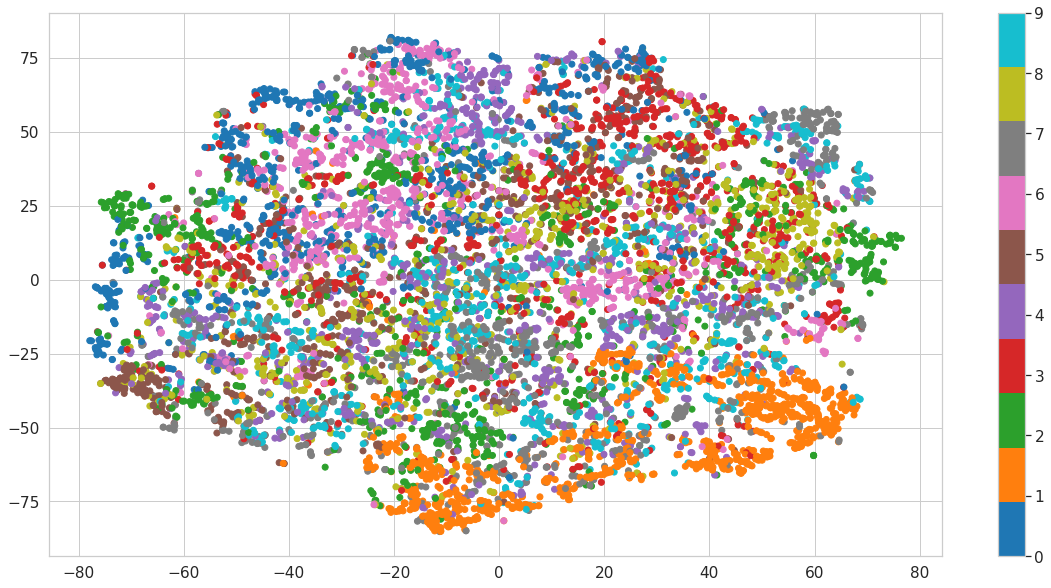

In [78]:
plt.figure(figsize=[20, 10])
graph = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=labels, cmap='tab10')
plt.colorbar(graph)
plt.colormaps()
plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
<ваш код получения латентных представлений, применения TSNE и визуализации>

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?